In [1]:
from pyspark.sql import SparkSession
allocated_memory = 18 * 0.75 

# create a SparkSession
spark = SparkSession.builder.appName("ReadJSON")\
.config("spark.executor.memory", "6g") \
.master("local[*]")  \
.config("spark.driver.memory", "4g") \
.config("spark.network.timeout", "800s")\
.config("spark.executor.heartbeatInterval", "200s")\
.config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.driver.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.memory.fraction", "0.8") \
.config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.3.3")\
.getOrCreate()

:: loading settings :: url = jar:file:/opt/homebrew/Cellar/apache-spark/3.5.1/libexec/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/kravisankaran/.ivy2/cache
The jars for the packages stored in: /Users/kravisankaran/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-834ef742-460d-46dc-98f2-9665aa549ded;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.3.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 54711)
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Users/kravisankaran/trial/lib/python3.12/site-pa

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, IntegerType, ArrayType
# targetUDF = F.udf(lambda x: 1 if x >= 4.0 else (0 if x == 3.0 else -1), IntegerType())
targetUDF = F.udf(lambda x: 1 if x >= 4.0 else 0, IntegerType())

In [3]:
json_objects = []
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, IntegerType
#"reviewerID": "A8WEXFRWX1ZHH", 
# "asin": "0209688726", 
# "style": {"Color:": " AC"}, 
# "reviewerName": "Goldengate",
# Define the schema
schema = StructType([
    StructField("overall", FloatType(), True),
    StructField("verified", BooleanType(), True),
    StructField("reviewTime", StringType(), True),
    StructField("reviewerID", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("style", StructType([StructField("Color:", StringType(), True)]), True),
    StructField("reviewerName", StringType(), True),
    StructField("reviewText", StringType(), True),
    StructField("unixReviewTime", IntegerType(), True)
    
])
def pre_process(chunk):
    print("Processing chunk")
    df = spark.createDataFrame(json_objects, schema=schema)
    reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
    unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
    unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
    df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
    return df_sentiment

In [ ]:
# import sys
# import json
# import os
# import shutil

# from pyspark.sql.functions import rand
# from pyspark.ml.pipeline import PipelineModel

# # Define the maximum file size in bytes (10MB)
# max_file_size = 10 * 1024 * 1024

# json_objects = []

# # Read the file line by line until the maximum file size is reached
# with open(json_training_file_path, 'r') as file:
#     total_size = 0
#     for line in file:
#         # Calculate the size of the current line
#         line_size = sys.getsizeof(line)

#         # If adding the current line exceeds the maximum file size, stop reading
#         if total_size + line_size > max_file_size:
#             print(line_size, total_size)
#             # Create a DataFrame from the list of JSON objects
#             df = spark.createDataFrame(json_objects)
#             reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
#             unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
#             df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
#             tokenizer = Tokenizer(inputCol  = "reviewText",
#                       outputCol = "token")
#             # Remove the rows with missing values and tokenize
#             df_train_tokenized = tokenizer.transform(df_sentiment.filter(unique_df.reviewText.isNotNull()))
#             # remove hashtags, call outs and web addresses
#             df4_train = df_train_tokenized.withColumn("tokens_re", removeWEBUDF(df_train_tokenized["token"]))
#             # remove non english characters
#             df4_train = df4_train.withColumn("tokens_clean", normalizeUDF(df4_train["tokens_re"]))
#             # rename columns
#             df5_train = df4_train.drop("token","tokens_re")
#             df5_train = df5_train.withColumnRenamed("tokens_clean", "tokens")
#             # remove reviews where the tokens array is empty, i.e. where it was just
#             # a hashtag, callout, numbers, web adress etc.
#             df6_train = df5_train.where(F.size(F.col("tokens")) > 0)
#             df_train_for_model = df6_train.select("reviewText","sentiment").withColumnRenamed("sentiment", "label")
#             shuffled_train_df = df_train_for_model.orderBy(rand())
#             if os.path.exists('bigram_pipeline_model'):
#                 loaded_model = PipelineModel.load('bigram_pipeline_model')
#                 stages_steps = loaded_model.stages
#                 updated_model = Pipeline(stages = stages_steps).fit(shuffled_train_df)
#                 shutil.rmtree('bigram_pipeline_model')
#             else:
#                 updated_model = bigram_pipeline.fit(shuffled_train_df)

#             PipelineModel.save(updated_model, 'bigram_pipeline_model')
#             print('Model saved')
#             json_objects = []
#             total_size = 0
#         # Otherwise, add the line to the list of JSON objects
#         json_objects.append(json.loads(line))
#         total_size += line_size



In [4]:
from nltk.stem.porter import PorterStemmer
from pyspark import keyword_only
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param


class PorterStemming(Transformer, HasInputCol, HasOutputCol):
    """
    PosterStemming class using the NLTK Porter Stemmer
    
    This comes from https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    Adapted to work with the Porter Stemmer from NLTK.
    """
    
    @keyword_only
    def __init__(self, 
                 inputCol  : str = None, 
                 outputCol : str = None, 
                 min_size  : int = None):
        """
        Constructor takes in the input column name, output column name,
        plus the minimum legnth of a token (min_size)
        """
        # call Transformer classes constructor since were extending it.
        super(Transformer, self).__init__()

        # set Parameter objects minimum token size
        self.min_size = Param(self, "min_size", "")
        self._setDefault(min_size=0)

        # set the input keywork arguments
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

        # initialize Stemmer object
        self.stemmer  = PorterStemmer()

        
    @keyword_only
    def setParams(self, 
                  inputCol  : str = None, 
                  outputCol : str = None, 
                  min_size  : int = None
      ) -> None:
        """
        Function to set the keyword arguemnts
        """
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    

    def _stem_func(self, words  : list) -> list:
        """
        Stemmer function call that performs stemming on a
        list of tokens in words and returns a list of tokens
        that have meet the minimum length requiremnt.
        """
        # We need a way to get min_size and cannot access it 
        # with self.min_size
        min_size       = self.getMinSize()

        # stem that actual tokens by applying 
        # self.stemmer.stem function to each token in 
        # the words list
        stemmed_words  = map(self.stemmer.stem, words)

        # now create the new list of tokens from
        # stemmed_words by filtering out those
        # that are not of legnth > min_size
        filtered_words = filter(lambda x: len(x) > min_size, stemmed_words)

        return list(filtered_words)
    
    def _transform(self, df: DataFrame) -> DataFrame:
        """
        Transform function is the method that is called in the 
        MLPipleline.  We have to override this function for our own use
        and have it call the _stem_func.

        Notice how it takes in a type DataFrame and returns type Dataframe
        """
        # Get the names of the input and output columns to use
        out_col       = self.getOutputCol()
        in_col        = self.getInputCol()

        # create the stemming function UDF by wrapping the stemmer 
        # method function
        stem_func_udf = F.udf(self._stem_func, ArrayType(StringType()))
        
        # now apply that UDF to the column in the dataframe to return
        # a new column that has the same list of words after being stemmed
        df2           = df.withColumn(out_col, stem_func_udf(df[in_col]))

        return df2
  
  
    def setMinSize(self,value):
        """
        This method sets the minimum size value
        for the _paramMap dictionary.
        """
        self._paramMap[self.min_size] = value
        return self

    def getMinSize(self) -> int:
        """
        This method uses the parent classes (Transformer)
        .getOrDefault method to get the minimum
        size of a token.
        """
        return self.getOrDefault(self.min_size)


In [8]:
import os

from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.pipeline import PipelineModel
import json 
def identify_model_type(model_path):
    # Check if metadata exists to identify the model type
    metadata_path = os.path.join(model_path, 'metadata')
    if os.path.exists(metadata_path):
        with open(os.path.join(metadata_path, 'part-00000'), 'r') as file:
            metadata = json.load(file)
            return metadata['class']
    else: 
        try:
            model = CrossValidatorModel.load(model_path)
            del model
            return "CrossValidatorModel"
        except Exception as e1:
            # Try loading the model as PipelineModel
            try:
                model = PipelineModel.load(model_path)
                del model
                return "PipelineModel"
            except Exception as e2:
                return "Unknown model type"

In [6]:
# Building the pipeline for nlp transformers
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer, Stemmer

from pyspark.ml.feature import HashingTF, IDF, NGram
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

paramGrid = ParamGridBuilder() 

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
 

    nlpPipeline = Pipeline(stages=[
        documentAssembler, 
        tokenizer,
        stopwords_cleaner
    ])
    
    return nlpPipeline

def get_cross_val_pipeline():
    bigram2 = NGram(inputCol="stemmed", outputCol="bigrams", n=2)

    tf6 = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)

    idf = IDF(inputCol="rawFeatures", outputCol="features")

    lr = LogisticRegression(maxIter=10)

    paramGrid = ParamGridBuilder() \
        .addGrid(idf.minDocFreq, [2, 5]) \
        .addGrid(lr.regParam, [0.0, 0.1]) \
        .build()
    stemmer = PorterStemming(inputCol="token", outputCol="stemmed")
 
    stemmed_bigram_pipeline = Pipeline(stages=[bigram2, tf6, idf, lr])
    return (stemmed_bigram_pipeline, paramGrid, stemmer)

def get_crossval_evaluator():
    stemmed_bigram_pipeline, paramGrid, stemmer = get_cross_val_pipeline()
    crossval = CrossValidator(estimator= stemmed_bigram_pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=3,
                              parallelism=2
                              )
    return (crossval, stemmer)


<>:31: SyntaxWarning: invalid escape sequence '\w'
<>:31: SyntaxWarning: invalid escape sequence '\w'
/var/folders/1d/rj0w684n0z533z06yt6wyj2h0000gn/T/ipykernel_61047/41447811.py:31: SyntaxWarning: invalid escape sequence '\w'
  .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)


In [ ]:
# Define the maximum file size in bytes (10MB)
max_file_size = 10 * 1024 * 1024
json_training_file_path = "combined_train_data_chunked_10mb_latest.json"
import sys
import json
import os
import shutil
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.pipeline import PipelineModel
 


def transform_chunk(df):
    nlpPipeline = get_nlp_pipeline()
    tokenized_df = nlpPipeline.fit(df).transform(df)
    tokenized_df.show(1)
    #tokenized_df.select("cleanTokens.result").show(1)
    df6_train = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
    df_train_for_model = df6_train.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
    return df_train_for_model

def run_cross_validation(df_train, pipeline, stem_pipeline, run):
    stages_steps = []
    train_stem = stem_pipeline.transform(df_train)\
                          .where(F.size(F.col("stemmed")) >= 1)
    print("Run %d" % run)
    if os.path.exists('crossval_pipeline_model'):
        model_type = identify_model_type('crossval_pipeline_model')
        print("Model type: %s" % model_type)
        if "CrossValidatorModel" in model_type:
            loaded_model = CrossValidatorModel.load('crossval_pipeline_model')
            stages_steps = loaded_model.bestModel.stages 
            updated_model = pipeline.fit(train_stem)
        elif "PipelineModel" in model_type:
            loaded_model = PipelineModel.load('crossval_pipeline_model')
            stages_steps = loaded_model.stages
            updated_model = Pipeline(stages = stages_steps).fit(train_stem)
        else:
            raise ValueError("Unsupported or unknown model type")
        updated_model.write().overwrite().save('crossval_pipeline_model')
    else:
        print("Printing data frame for training")
        train_stem.show(1)
        updated_model = pipeline.fit(train_stem)
        updated_model.write().overwrite().save('crossval_pipeline_model')
    run +=1
    print('Model saved for current chunk')
    return run

run = 0
with open(json_training_file_path, 'r') as file:
    total_size = 0
    for line in file:
        line_size = sys.getsizeof(line)
        # print("Current line size: %d, Total size: %d" % (line_size, total_size))
        if total_size + line_size >= max_file_size:
            print("Current line size: %d, Total size: %d" % (line_size, total_size))
            df  = pre_process(json_objects)
            print("Show the first row of the preprocessed chunk:")
            df.show(1)
            df_train = transform_chunk(df)
            print("Show the first row of the transformed chunk:")
            df_train.show(1)
            crossval, stemmer = get_crossval_evaluator()
            run = run_cross_validation(df_train, crossval, stemmer, run)
            del df
            del df_train
            json_objects = []
            total_size = 0
        json_objects.append(json.loads(line))
        total_size += line_size


In [9]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer
import json

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
 

    nlpPipeline = Pipeline(stages=[
        documentAssembler, 
        tokenizer,
        stopwords_cleaner
    ])
    
    return nlpPipeline

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Load the model
model_type = identify_model_type('crossval_pipeline_model')
print("Model type: %s" % model_type)
if "CrossValidatorModel" in model_type:
    loaded_model = CrossValidatorModel.load('crossval_pipeline_model')
else:
    loaded_model = PipelineModel.load('crossval_pipeline_model')

# get the name of the metric used
evaluator.getMetricName()
print("Loading test data:")
df = spark.read.schema(schema).json("combined_test_data_chunked_10mb_latest.json")
reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
print("Preprocessed test data:")
df_sentiment.show(1)
nlpPipeline = get_nlp_pipeline()
tokenized_df = nlpPipeline.fit(df_sentiment).transform(df_sentiment)
df_test = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
transformed_test = df_test.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
print("Transformed test data:")
transformed_test.show(1)
stemmer = PorterStemming(inputCol="token", outputCol="stemmed")
test_stem = stemmer.transform(transformed_test)\
                          .where(F.size(F.col("stemmed")) >= 1)
print("Stemmed test data:")
test_stem.show(1)
predictions = loaded_model.transform(test_stem)
print("Predictions:")
predictions.show(1)
# Evaluate the model
score = evaluator.evaluate(predictions)

print("AUC SCORE: {}".format(score))


<>:25: SyntaxWarning: invalid escape sequence '\w'
<>:25: SyntaxWarning: invalid escape sequence '\w'
/var/folders/1d/rj0w684n0z533z06yt6wyj2h0000gn/T/ipykernel_61047/1415706887.py:25: SyntaxWarning: invalid escape sequence '\w'
  .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)


Model type: org.apache.spark.ml.tuning.CrossValidatorModel


Loading test data:
Preprocessed test data:


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    3.0|A0020356UF96ZV361ST|B00FDXFFW2|I guess you can s...|        0|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Transformed test data:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I guess you can s...|    0|[guess, say, happ...|
+--------------------+-----+--------------------+
only showing top 1 row

Stemmed test data:


+--------------------+-----+--------------------+--------------------+
|          reviewText|label|               token|             stemmed|
+--------------------+-----+--------------------+--------------------+
|I guess you can s...|    0|[guess, say, happ...|[guess, say, happ...|
+--------------------+-----+--------------------+--------------------+
only showing top 1 row

Predictions:


24/04/26 19:36:30 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|          reviewText|label|               token|             stemmed|             bigrams|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|I guess you can s...|    0|[guess, say, happ...|[guess, say, happ...|[guess say, say h...|(200000,[3744,228...|(200000,[3744,228...|[-1.5586729090191...|[0.17383715841670...|       1.0|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 1 row



24/04/26 19:36:57 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


AUC SCORE: 0.755314188739738


In [10]:
predictedAndLabels = predictions.select(["prediction","label"])\
                                .rdd.map(lambda r : (float(r[0]), float(r[1])))


In [11]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

/Users/kravisankaran/trial/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/26 19:58:39 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/04/26 19:58:44 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


Test Set Accuracy: 0.8511374576573364


[[  65862.  369975.]
 [  47510. 2321153.]]


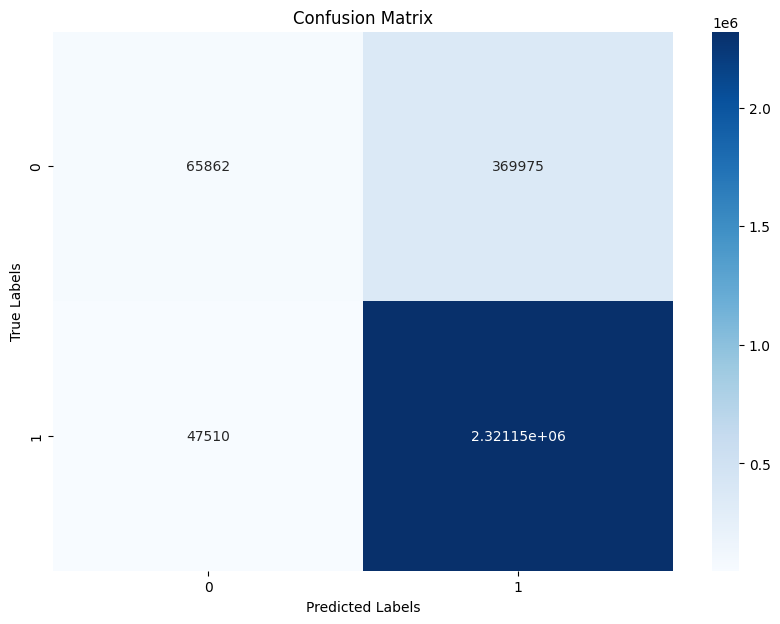

In [15]:
# Sonia and Emma - you need to run this plot 


confusion_matrix = metrics.confusionMatrix().toArray()

print(confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  # 'g' formats numbers as integers
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
